# House Price Predictor

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,50,RL,51.0,4712,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Abnorml,121600
996,997,20,RL,NaN,10659,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,COD,Normal,136500
997,998,20,RL,NaN,11717,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,185000
998,999,30,RM,60.0,9786,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,91000


In [4]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [167]:
NVAR = 22
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
# print(target_corr)

# Select only the top NVAR features with the highest correlation with 'SalesPrice'
top_features = target_corr.head(NVAR).index
print(f"Selected top {NVAR} features:", list(top_features))

# Define input features (X) and target variable (y).
X = data_clean[top_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -----------------------------
# 5. Define the Neural Network Model
# -----------------------------
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer for regression
        # self.fc3 = nn.Linear(32, 32)
        # self.fc4 = nn.Linear(32, 1)  # Output layer for regression
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.relu(self.fc3(x))
        # x = self.fc4(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HousePriceModel(input_dim=X_train.shape[1]).to(device)

# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# -----------------------------
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

print("")

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
# Test Mean Squared Error: 935741376.0

# Calculate in-sample R^2 value
y_train_pred = model(X_train_tensor).detach().numpy()
ss_total = np.sum((y_train - np.mean(y_train))**2)
ss_residual = np.sum((y_train - y_train_pred)**2)
r2_score = 1 - (ss_residual / ss_total)
print(f'In-sample R^2: {r2_score:.4f}')

# Calculate out-of-sample R^2 value
y_test_pred = model(X_test_tensor).detach().numpy()
ss_total_test = np.sum((y_test - np.mean(y_test))**2)
ss_residual_test = np.sum((y_test - y_test_pred)**2)
r2_score_test = 1 - (ss_residual_test / ss_total_test)
print(f'Out-of-sample R^2: {r2_score_test:.4f}')

Selected top 22 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'BsmtFinSF1', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtUnfSF', 'BsmtFullBath', 'BedroomAbvGr', 'ScreenPorch', 'KitchenAbvGr']
Epoch [100/2000], Loss: 7799588761.6000
Epoch [200/2000], Loss: 4084126269.4400
Epoch [300/2000], Loss: 2028165918.7200
Epoch [400/2000], Loss: 1227401406.7200
Epoch [500/2000], Loss: 1028447077.1200
Epoch [600/2000], Loss: 946478273.2800
Epoch [700/2000], Loss: 898815645.4400
Epoch [800/2000], Loss: 867832597.7600
Epoch [900/2000], Loss: 846629139.2000
Epoch [1000/2000], Loss: 830634881.2800
Epoch [1100/2000], Loss: 817080232.9600
Epoch [1200/2000], Loss: 805575532.8000
Epoch [1300/2000], Loss: 795623390.0800
Epoch [1400/2000], Loss: 786143296.6400
Epoch [1500/2000], Loss: 776723403.5200
Epoch [1600/2000], Loss: 768219450.2400
Epoch [1700/2000], Loss: 7606

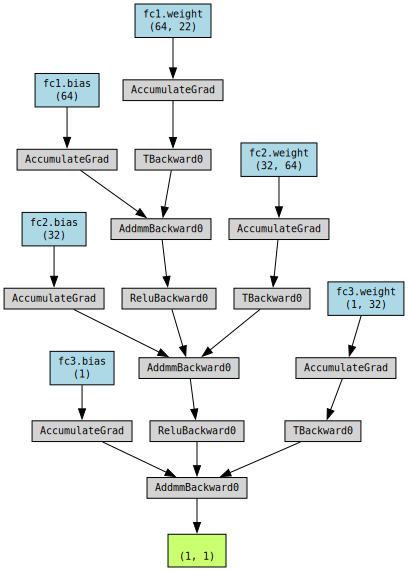

In [168]:
#Visualize the neural net (for reference)
from torchviz import make_dot
x=torch.randn(1, X_train.shape[1])
y=model(x)
make_dot(y, params=dict(model.named_parameters()))

In [169]:
# -----------------------------
# X. Load the test data and predict/write to predictions.csv
# -----------------------------
data_testset = pd.read_csv('test.csv')

X_testset = data_testset[top_features].values
X_testset = scaler.transform(X_testset)
X_testset_tensor = torch.tensor(X_testset, dtype=torch.float32)

y_testset_pred = model(X_testset_tensor).detach().numpy()
data_testset["SALEPRICE"] = y_testset_pred
data_testset["ID"] = data_testset["Id"]
print(data_testset.loc[:,['ID', 'SALEPRICE']])
data_testset.to_csv("predictions.csv", columns=['ID', 'SALEPRICE'], header=True, index=False)

       ID      SALEPRICE
0    1001   90014.093750
1    1002   84997.796875
2    1003  254184.656250
3    1004  125448.273438
4    1005  225396.578125
..    ...            ...
455  1456  179948.468750
456  1457  244005.593750
457  1458  222172.515625
458  1459  142866.093750
459  1460  159040.593750

[460 rows x 2 columns]


In [166]:
# Used to find the seemingly best number of independent variables => Best out-of-sample R^2 at NVAR=22.
# there seems overfitting for NVAR > 25
def iterateOverNvar(minN, maxN):
    for NVAR in range(minN,maxN+1):
        # -----------------------------
        # 3. Feature Selection
        # -----------------------------
        # Compute the correlation matrix using only the cleaned numeric data.
        corr_matrix = data_clean.corr()
        
        # Compute absolute correlations of features with the target and drop the target itself.
        target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)
        # target_corr = corr_matrix['SalePrice'].drop('SalePrice').drop("GarageArea").abs().sort_values(ascending=False)
        # print(target_corr)
        
        # Select only the top NVAR features with the highest correlation with 'SalesPrice'
        top_features = target_corr.head(NVAR).index
        print(f"Selected top {NVAR} features:", list(top_features))
        
        # Define input features (X) and target variable (y).
        X = data_clean[top_features].values
        y = data_clean['SalePrice'].values.reshape(-1, 1)
        
        # -----------------------------
        # 4. Data Preprocessing
        # -----------------------------
        # Split the data into training and testing sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Standardize features to improve training stability.
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Convert the numpy arrays to PyTorch tensors.
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        # Create a TensorDataset and DataLoader for batch processing.
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        # -----------------------------
        # 5. Define the Neural Network Model
        # -----------------------------
        class HousePriceModel(nn.Module):
            def __init__(self, input_dim):
                super(HousePriceModel, self).__init__()
                self.fc1 = nn.Linear(input_dim, 64)
                self.fc2 = nn.Linear(64, 32)
                self.fc3 = nn.Linear(32, 1)  # Output layer for regression
                self.relu = nn.ReLU()
            
            def forward(self, x):
                x = self.relu(self.fc1(x))
                x = self.relu(self.fc2(x))
                x = self.fc3(x)
                return x
        
        # Use GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = HousePriceModel(input_dim=X_train.shape[1]).to(device)
        
        # -----------------------------
        # 6. Set Up Loss Function and Optimizer
        # -----------------------------
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # -----------------------------
        # 7. Train the Model
        # -----------------------------
        num_epochs = 1000
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * batch_X.size(0)
            
            epoch_loss = running_loss / len(train_dataset)
            if (epoch + 1) % 100 == 0:
                pass
                # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # -----------------------------
        # 8. Evaluate the Model
        # -----------------------------
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor.to(device))
            test_loss = criterion(predictions, y_test_tensor.to(device)).item()
            print("Test Mean Squared Error:", test_loss)
            
        # Optionally, to evaluate using scikit-learn's MSE:
        predictions_np = predictions.cpu().numpy()
        mse = mean_squared_error(y_test, predictions_np)
        print("Test MSE (scikit-learn):", mse)
        # Test Mean Squared Error: 935741376.0
        
        # Calculate in-sample R^2 value
        y_train_pred = model(X_train_tensor).detach().numpy()
        ss_total = np.sum((y_train - np.mean(y_train))**2)
        ss_residual = np.sum((y_train - y_train_pred)**2)
        r2_score = 1 - (ss_residual / ss_total)
        print(f'In-sample R^2: {r2_score:.4f}')
        
        # Calculate out-of-sample R^2 value
        y_test_pred = model(X_test_tensor).detach().numpy()
        ss_total_test = np.sum((y_test - np.mean(y_test))**2)
        ss_residual_test = np.sum((y_test - y_test_pred)**2)
        r2_score_test = 1 - (ss_residual_test / ss_total_test)
        print(f'Out-of-sample R^2: {r2_score_test:.4f}')
        print("")


iterateOverNvar(1,35)

Selected top 1 features: ['OverallQual']
Test Mean Squared Error: 1416107520.0
Test MSE (scikit-learn): 1416107604.239617
In-sample R^2: 0.6830
Out-of-sample R^2: 0.6609

Selected top 2 features: ['OverallQual', 'GrLivArea']
Test Mean Squared Error: 1082990208.0
Test MSE (scikit-learn): 1082990104.4648767
In-sample R^2: 0.7773
Out-of-sample R^2: 0.7407

Selected top 3 features: ['OverallQual', 'GrLivArea', 'GarageCars']
Test Mean Squared Error: 907079680.0
Test MSE (scikit-learn): 907079723.73229
In-sample R^2: 0.7973
Out-of-sample R^2: 0.7828

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
Test Mean Squared Error: 938710848.0
Test MSE (scikit-learn): 938710886.7627994
In-sample R^2: 0.8006
Out-of-sample R^2: 0.7752

Selected top 5 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
Test Mean Squared Error: 914945984.0
Test MSE (scikit-learn): 914945961.032142
In-sample R^2: 0.8248
Out-of-sample R^2: 0.7809

Selected top 

In [158]:
#Attempt to predict with Random Forest
# # Define the neural network
# class RandomForestNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_trees):
#         super(RandomForestNN, self).__init__()
#         self.trees = nn.ModuleList([nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, output_size)
#         ) for _ in range(num_trees)])
    
#     def forward(self, x):
#         outputs = torch.stack([tree(x) for tree in self.trees], dim=0)
#         return outputs.mean(dim=0)  # Aggregate outputs like random forest



# NVAR = 5

# corr_matrix = data_clean.corr()

# target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# top_features = target_corr.head(NVAR).index
# print(f"Selected top {NVAR} features:", list(top_features))

# X = data_clean[top_features].values
# y = data_clean['SalePrice'].values.reshape(-1, 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert the numpy arrays to PyTorch tensors.
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Create a TensorDataset and DataLoader for batch processing.
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Use GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RandomForestNN(input_size=X_train.shape[1], hidden_size=16, output_size=1, num_trees=30).to(device)

# # -----------------------------
# # 6. Set Up Loss Function and Optimizer
# # -----------------------------
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # -----------------------------
# # 7. Train the Model
# # -----------------------------
# num_epochs = 1000
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item() * batch_X.size(0)
    
#     epoch_loss = running_loss / len(train_dataset)
#     if (epoch + 1) % 100 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# # -----------------------------
# # 8. Evaluate the Model
# # -----------------------------
# model.eval()
# with torch.no_grad():
#     predictions = model(X_test_tensor.to(device))
#     test_loss = criterion(predictions, y_test_tensor.to(device)).item()
#     print("Test Mean Squared Error:", test_loss)

# print("")

# # Optionally, to evaluate using scikit-learn's MSE:
# predictions_np = predictions.cpu().numpy()
# mse = mean_squared_error(y_test, predictions_np)
# print("Test MSE (scikit-learn):", mse)
# # Test Mean Squared Error: 935741376.0

# # Calculate in-sample R^2 value
# y_train_pred = model(X_train_tensor).detach().numpy()
# ss_total = np.sum((y_train - np.mean(y_train))**2)
# ss_residual = np.sum((y_train - y_train_pred)**2)
# r2_score = 1 - (ss_residual / ss_total)
# print(f'In-sample R^2: {r2_score:.4f}')

# # Calculate out-of-sample R^2 value
# y_test_pred = model(X_test_tensor).detach().numpy()
# ss_total_test = np.sum((y_test - np.mean(y_test))**2)
# ss_residual_test = np.sum((y_test - y_test_pred)**2)
# r2_score_test = 1 - (ss_residual_test / ss_total_test)
# print(f'Out-of-sample R^2: {r2_score_test:.4f}')

Selected top 5 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
Epoch [100/1000], Loss: 3489768320.0000
Epoch [200/1000], Loss: 1432762749.4400
Epoch [300/1000], Loss: 1297438944.0000
Epoch [400/1000], Loss: 1248202237.4400
Epoch [500/1000], Loss: 1225911660.8000
Epoch [600/1000], Loss: 1210979206.4000
Epoch [700/1000], Loss: 1203040547.8400
Epoch [800/1000], Loss: 1200113719.0400
Epoch [900/1000], Loss: 1193221626.8800
Epoch [1000/1000], Loss: 1189109120.0000
Test Mean Squared Error: 873110592.0

Test MSE (scikit-learn): 873110616.2522037
In-sample R^2: 0.8298
Out-of-sample R^2: 0.7909
